In [1]:
import re
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import requests
import feather
from pytrends.request import TrendReq
import pytrends
import pickle
import patsy
from sklearn.model_selection import cross_validate,train_test_split
from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNet
from sklearn import preprocessing
from sklearn.feature_selection import f_regression
from sklearn.metrics import mean_absolute_error
import sklearn.metrics
import statsmodels.api as sm
import seaborn as sns
from collections import defaultdict
import heapq
import random
import time
from prettytable import PrettyTable
import warnings 
#only doing this because whenever I use f_regression, there 
#there is some division by zero error when calculating p values and f stat
#for the intercept.
warnings.filterwarnings('ignore')

In [2]:
df_full =feather.read_dataframe("DataFrameforEDAandRegression.feather")

In [3]:
df_full.columns

Index(['club_name', 'player_name', 'age', 'club_involved_name',
       'transfer_movement', 'fee_cleaned', 'year', 'pos_Attacking Midfield',
       'pos_Central Midfield', 'pos_Centre-Back', 'pos_Centre-Forward',
       'pos_Defensive Midfield', 'pos_Goalkeeper', 'pos_Left Midfield',
       'pos_Left Winger', 'pos_Left-Back', 'pos_Right Midfield',
       'pos_Right Winger', 'pos_Right-Back', 'pos_Second Striker',
       'league_1 Bundesliga', 'league_Championship', 'league_Eredivisie',
       'league_Liga Nos', 'league_Ligue 1', 'league_Premier League',
       'league_Premier Liga', 'league_Primera Division', 'league_Serie A',
       'name_under', 'goals', 'apps', 'Name', 'height', 'Season_Transfer',
       'Nation', 'Pos', 'Squad', 'Age', 'Born', 'Apps', 'Starts', 'Subs',
       'Min', 'Mn/Ap', 'Gls', 'Ast', 'PK', 'PKatt', 'Fls', 'CrdY', 'CrdR',
       'SoT', 'Player_name', 'Player_under'],
      dtype='object')

In [4]:
#sorting to get a good idea of the range of fee values
sorted_fees = df_full['fee_cleaned'].sort_values(ascending=True)
sorted_log_fees = np.log(df_full['fee_cleaned']).sort_values(ascending=True)

In [5]:
sorted_fees.shape

(807,)

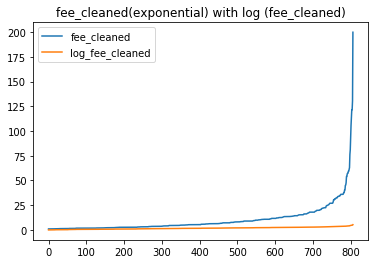

In [6]:
#our target
plt.plot(np.arange(0,807),sorted_fees)
plt.plot(np.arange(0,807), sorted_log_fees) 
plt.title("fee_cleaned(exponential) with log (fee_cleaned)");
plt.legend(["fee_cleaned", "log_fee_cleaned"]);

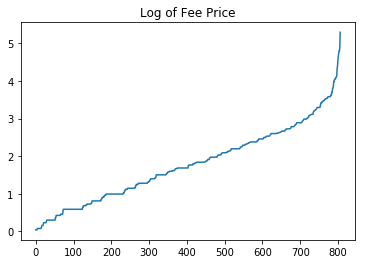

In [7]:
plt.plot(np.arange(0,807),sorted_log_fees)
plt.title("Log of Fee Price");

In [8]:
!ls *.feather

DataFrameforEDAandRegression.feather df_Performance.feather
Test_fifa_small.feather              df_g_trends.feather
df_15_16_17_18_in_goals_apps.feather fifa_df.feather
df_FBRefStatistics.feather           perf_fifa.feather


In [9]:
df_corr = feather.read_dataframe("df_Performance.feather")

In [10]:
df_corr = df_corr.set_index("Season_Transfer")

In [11]:
cols_keep = ['fee_cleaned', "year", "height", "Apps", "Gls", "Ast", "SoT","CrdR"]

In [12]:
df_corr = df_corr[cols_keep]

## Observations from heatmap of correlation below
Target feature "fee_cleaned" has noticeable correlations with Appearances, Goals, Assists, and Shots on target, yet Shots on target has a very high collinearity with goals so I will probaly leave this feature out

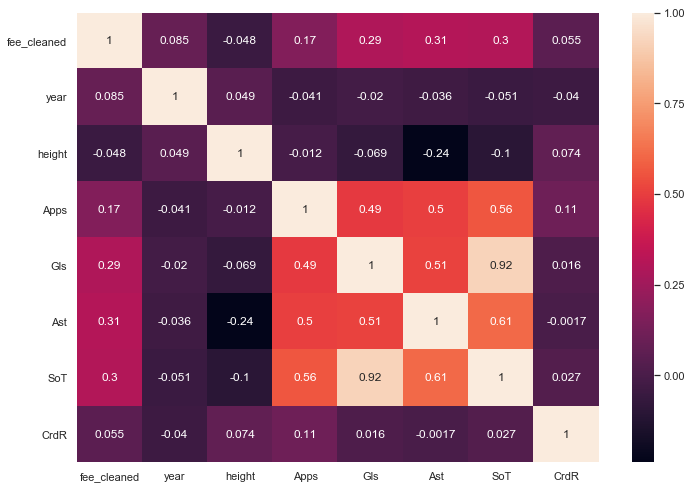

In [13]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(df_corr.corr(), annot=True);

### In below cell I am just fixing some column named to not have spacies, just to make easier for patsy

In [14]:
df_full.columns

Index(['club_name', 'player_name', 'age', 'club_involved_name',
       'transfer_movement', 'fee_cleaned', 'year', 'pos_Attacking Midfield',
       'pos_Central Midfield', 'pos_Centre-Back', 'pos_Centre-Forward',
       'pos_Defensive Midfield', 'pos_Goalkeeper', 'pos_Left Midfield',
       'pos_Left Winger', 'pos_Left-Back', 'pos_Right Midfield',
       'pos_Right Winger', 'pos_Right-Back', 'pos_Second Striker',
       'league_1 Bundesliga', 'league_Championship', 'league_Eredivisie',
       'league_Liga Nos', 'league_Ligue 1', 'league_Premier League',
       'league_Premier Liga', 'league_Primera Division', 'league_Serie A',
       'name_under', 'goals', 'apps', 'Name', 'height', 'Season_Transfer',
       'Nation', 'Pos', 'Squad', 'Age', 'Born', 'Apps', 'Starts', 'Subs',
       'Min', 'Mn/Ap', 'Gls', 'Ast', 'PK', 'PKatt', 'Fls', 'CrdY', 'CrdR',
       'SoT', 'Player_name', 'Player_under'],
      dtype='object')

In [15]:
df_full.columns=['club_name', 'player_name', 'age', 'club_involved_name',
       'transfer_movement', 'fee_cleaned', 'year', 'pos_Attacking Midfield',
       'pos_Central Midfield', 'pos_Centre-Back', 'pos_Centre-Forward',
       'pos_Defensive Midfield', 'pos_Goalkeeper', 'pos_Left Midfield',
       'pos_Left Winger', 'pos_Left-Back', 'pos_Right Midfield',
       'pos_Right Winger', 'pos_Right-Back', 'pos_Second Striker',
       'league_1Bundesliga', 'league_Championship', 'league_Eredivisie',"league_Liga_nos",
        "league_Ligue_1", "league_PremierLeague", "league_Premier_Liga", 
        "league_PrimeraDivision", "league_SerieA",'name_under', 'goals', 'apps', 'Name', 'height', 'Season_Transfer',
       'Nation', 'Pos', 'Squad', 'Age', 'Born', 'Apps', 'Starts', 'Subs',
       'Min', 'Mn/Ap', 'Gls', 'Ast', 'PK', 'PKatt', 'Fls', 'CrdY', 'CrdR',
       'SoT', 'Player_name', 'Player_under']

In [16]:
df_full.columns

Index(['club_name', 'player_name', 'age', 'club_involved_name',
       'transfer_movement', 'fee_cleaned', 'year', 'pos_Attacking Midfield',
       'pos_Central Midfield', 'pos_Centre-Back', 'pos_Centre-Forward',
       'pos_Defensive Midfield', 'pos_Goalkeeper', 'pos_Left Midfield',
       'pos_Left Winger', 'pos_Left-Back', 'pos_Right Midfield',
       'pos_Right Winger', 'pos_Right-Back', 'pos_Second Striker',
       'league_1Bundesliga', 'league_Championship', 'league_Eredivisie',
       'league_Liga_nos', 'league_Ligue_1', 'league_PremierLeague',
       'league_Premier_Liga', 'league_PrimeraDivision', 'league_SerieA',
       'name_under', 'goals', 'apps', 'Name', 'height', 'Season_Transfer',
       'Nation', 'Pos', 'Squad', 'Age', 'Born', 'Apps', 'Starts', 'Subs',
       'Min', 'Mn/Ap', 'Gls', 'Ast', 'PK', 'PKatt', 'Fls', 'CrdY', 'CrdR',
       'SoT', 'Player_name', 'Player_under'],
      dtype='object')

## Holdout a test set for later, this test set is year 2018 

In [17]:
len(df_full)

807

In [18]:
train_indexes = (df_full.loc[(df_full['year']==2015.0) | 
                             (df_full['year']==2016.0) | 
                             (df_full['year']==2017.0)]).index

In [19]:
len(train_indexes)

614

In [20]:
test_indexes = df_full.loc[(df_full['year']==2018.0)].index

In [21]:
len(test_indexes)

193

In [22]:
df_train = df_full.iloc[train_indexes,:]
df_train.shape

(614, 55)

In [23]:
df_test = df_full.iloc[test_indexes,:]
df_test.shape

(193, 55)

## In the bottom 4 Cells I am Normalizing my independent Features

In [24]:
for num_column in df_train.select_dtypes(include=[np.number]):
    if num_column=="fee_cleaned":
        continue
    column_mean = df_train[num_column].mean()
    column_std = df_train[num_column].std() 
    df_train[num_column] = (df_train[num_column]-column_mean) / column_std
    

In [25]:
for num_column in df_test.select_dtypes(include=[np.number]):
    if num_column=="fee_cleaned":
        continue
    column_mean = df_test[num_column].mean()
    column_std = df_test[num_column].std() 
    df_test[num_column] = (df_test[num_column]-column_mean) / column_std

In [26]:
y,X = patsy.dmatrices("fee_cleaned ~ age + year + height + Apps + Gls + Ast",data=df_train)

In [27]:
#these x,y vectors will later be used for cross validation to test out 
#different feature and hyperparameter combinations with cross validation
x_y_non_fifa = {}
x_y_fifa = {}

In [28]:
x_y_non_fifa["performance"] = (X,y)

In [29]:
def fit_ols_split(X,y):
    y=y.ravel()
    column_names = X.design_info.column_names
    model = sm.OLS(y,X)
    results = model.fit()
    F,pvals = f_regression(X,y)
    t = PrettyTable(["Parameter", 'Values', "F Stat", "P Value"])
    for name,value,Fstat,p in zip(column_names, results.params,F,pvals):
        t.add_row([name,round(value,3), round(Fstat,3),round(p,3)])   
    print(t)
    print(f"\nR Squared: {round(results.rsquared,3)}")
    print(f"Adj. R Squared: {round(results.rsquared_adj,3)}")

In [30]:
def fit_log_ols_split(X,y):
    y=y.ravel()
    column_names = X.design_info.column_names
    y_log = np.log(y)
    model = sm.OLS(y_log,X)
    results = model.fit()
    F,pvals = f_regression(X,y)
    t = PrettyTable(["Parameter", 'Values', "F Stat", "P Value"])
    for name,value,Fstat,p in zip(column_names, results.params,F,pvals):
        t.add_row([name,round(value,3), round(Fstat,3),round(p,3)])   
    print(t)
    print(f"\nR Squared: {round(results.rsquared,3)}")
    print(f"Adj. R Squared: {round(results.rsquared_adj,3)}")
    

In [31]:
fit_ols_split(X,y)

+-----------+--------+--------+---------+
| Parameter | Values | F Stat | P Value |
+-----------+--------+--------+---------+
| Intercept | 10.097 |  nan   |   nan   |
|    age    | -1.369 | 2.101  |  0.148  |
|    year   | 1.551  | 6.794  |  0.009  |
|   height  | 0.139  | 0.341  |   0.56  |
|    Apps   | -1.248 | 32.318 |   0.0   |
|    Gls    | 3.808  | 81.713 |   0.0   |
|    Ast    | 4.431  | 93.39  |   0.0   |
+-----------+--------+--------+---------+

R Squared: 0.194
Adj. R Squared: 0.186


In [32]:
fit_log_ols_split(X,y)

+-----------+--------+--------+---------+
| Parameter | Values | F Stat | P Value |
+-----------+--------+--------+---------+
| Intercept |  1.78  |  nan   |   nan   |
|    age    | -0.137 | 2.101  |  0.148  |
|    year   | 0.065  | 6.794  |  0.009  |
|   height  | 0.001  | 0.341  |   0.56  |
|    Apps   | 0.076  | 32.318 |   0.0   |
|    Gls    | 0.218  | 81.713 |   0.0   |
|    Ast    | 0.199  | 93.39  |   0.0   |
+-----------+--------+--------+---------+

R Squared: 0.187
Adj. R Squared: 0.179


## Including League Dummy Variables that indicate which country the purchasing club is from, in this case, the French League is the base case

In [33]:
y_league,X_league = patsy.dmatrices("fee_cleaned ~ age + year + height + Apps + Gls + Ast + league_1Bundesliga + league_Championship+league_Eredivisie+ league_Liga_nos + league_PremierLeague+league_Premier_Liga+league_PrimeraDivision+league_SerieA",data=df_train)



In [34]:
x_y_non_fifa['performance_w_league'] = (X_league,y_league) 

In [35]:
X_league.shape
y_league.shape

(614, 1)

## As Seen below although including dummy variables for league improves the adjusted R squared, the high p values for many of the dummy league variables indicate I should try leaving them out and perhaps engineer a different statistic that can reflect quality of team/league that one plays in

In [36]:
fit_ols_split(X_league,y_league)

+------------------------+--------+--------+---------+
|       Parameter        | Values | F Stat | P Value |
+------------------------+--------+--------+---------+
|       Intercept        | 10.097 |  nan   |   nan   |
|          age           | -1.353 | 2.101  |  0.148  |
|          year          | 1.551  | 6.794  |  0.009  |
|         height         | 0.523  | 0.341  |   0.56  |
|          Apps          | -1.492 | 32.318 |   0.0   |
|          Gls           | 3.558  | 81.713 |   0.0   |
|          Ast           | 4.545  | 93.39  |   0.0   |
|   league_1Bundesliga   | -2.027 | 3.132  |  0.077  |
|  league_Championship   | -2.681 | 14.641 |   0.0   |
|   league_Eredivisie    | -2.252 | 2.383  |  0.123  |
|    league_Liga_nos     | -0.482 | 0.157  |  0.692  |
|  league_PremierLeague  | -0.014 | 22.246 |   0.0   |
|  league_Premier_Liga   | -1.245 | 1.982  |   0.16  |
| league_PrimeraDivision | -0.349 | 4.085  |  0.044  |
|     league_SerieA      | -2.188 | 4.474  |  0.035  |
+---------

In [37]:
fit_log_ols_split(X_league,y_league)

+------------------------+--------+--------+---------+
|       Parameter        | Values | F Stat | P Value |
+------------------------+--------+--------+---------+
|       Intercept        |  1.78  |  nan   |   nan   |
|          age           | -0.14  | 2.101  |  0.148  |
|          year          | 0.074  | 6.794  |  0.009  |
|         height         | 0.024  | 0.341  |   0.56  |
|          Apps          | 0.051  | 32.318 |   0.0   |
|          Gls           | 0.196  | 81.713 |   0.0   |
|          Ast           | 0.205  | 93.39  |   0.0   |
|   league_1Bundesliga   | -0.074 | 3.132  |  0.077  |
|  league_Championship   | -0.19  | 14.641 |   0.0   |
|   league_Eredivisie    | -0.168 | 2.383  |  0.123  |
|    league_Liga_nos     | -0.009 | 0.157  |  0.692  |
|  league_PremierLeague  | 0.156  | 22.246 |   0.0   |
|  league_Premier_Liga   | -0.084 | 1.982  |   0.16  |
| league_PrimeraDivision | -0.004 | 4.085  |  0.044  |
|     league_SerieA      | -0.09  | 4.474  |  0.035  |
+---------

In [38]:
df_full.columns

Index(['club_name', 'player_name', 'age', 'club_involved_name',
       'transfer_movement', 'fee_cleaned', 'year', 'pos_Attacking Midfield',
       'pos_Central Midfield', 'pos_Centre-Back', 'pos_Centre-Forward',
       'pos_Defensive Midfield', 'pos_Goalkeeper', 'pos_Left Midfield',
       'pos_Left Winger', 'pos_Left-Back', 'pos_Right Midfield',
       'pos_Right Winger', 'pos_Right-Back', 'pos_Second Striker',
       'league_1Bundesliga', 'league_Championship', 'league_Eredivisie',
       'league_Liga_nos', 'league_Ligue_1', 'league_PremierLeague',
       'league_Premier_Liga', 'league_PrimeraDivision', 'league_SerieA',
       'name_under', 'goals', 'apps', 'Name', 'height', 'Season_Transfer',
       'Nation', 'Pos', 'Squad', 'Age', 'Born', 'Apps', 'Starts', 'Subs',
       'Min', 'Mn/Ap', 'Gls', 'Ast', 'PK', 'PKatt', 'Fls', 'CrdY', 'CrdR',
       'SoT', 'Player_name', 'Player_under'],
      dtype='object')

# I want to try and Pick up on some interaction effects or any possible quadratic relationships between target "fee_cleaned" and independent features I am also going to leave out height, and year purchased from before because they also have high p values

### Goals Squared

In [39]:
y_gl_sq_w_lg,X_gl_sq_w_lg = patsy.dmatrices("fee_cleaned ~ age + Apps +Gls+ np.power(Gls,2) + Ast + np.power(Ast,2)",data=df_train)



In [40]:
fit_ols_split(X_gl_sq_w_lg,y_gl_sq_w_lg)

+------------------+--------+--------+---------+
|    Parameter     | Values | F Stat | P Value |
+------------------+--------+--------+---------+
|    Intercept     | 7.595  |  nan   |   nan   |
|       age        | -1.363 | 2.101  |  0.148  |
|       Apps       | 0.265  | 32.318 |   0.0   |
|       Gls        | 0.655  | 81.713 |   0.0   |
| np.power(Gls, 2) | 1.599  | 70.703 |   0.0   |
|       Ast        | 3.114  | 93.39  |   0.0   |
| np.power(Ast, 2) | 0.907  | 58.766 |   0.0   |
+------------------+--------+--------+---------+

R Squared: 0.221
Adj. R Squared: 0.214


In [41]:
fit_log_ols_split(X_gl_sq_w_lg,y_gl_sq_w_lg)

+------------------+--------+--------+---------+
|    Parameter     | Values | F Stat | P Value |
+------------------+--------+--------+---------+
|    Intercept     | 1.718  |  nan   |   nan   |
|       age        | -0.135 | 2.101  |  0.148  |
|       Apps       | 0.113  | 32.318 |   0.0   |
|       Gls        | 0.081  | 81.713 |   0.0   |
| np.power(Gls, 2) | 0.066  | 70.703 |   0.0   |
|       Ast        | 0.223  | 93.39  |   0.0   |
| np.power(Ast, 2) | -0.004 | 58.766 |   0.0   |
+------------------+--------+--------+---------+

R Squared: 0.193
Adj. R Squared: 0.186


## Young Players appear to be negatively correlated with cleaned fee which overall makes sense  as players usually do not reach their prime until ~25-27, however, teams tend to pay a premium for young talent that is proven to perform at a high level, so I want to see if there any important interaction effects between age w/ goals and assists

In [42]:
y_glssq_inter,X_glssq_inter = patsy.dmatrices("fee_cleaned ~ age*Gls +Ast + Apps +Gls+ np.power(Gls,2)",data=df_train)


In [43]:
x_y_non_fifa['gls_sq_interact_leagues'] = (X_glssq_inter,y_glssq_inter)

In [44]:
fit_ols_split(X_glssq_inter,y_glssq_inter)

+------------------+--------+--------+---------+
|    Parameter     | Values | F Stat | P Value |
+------------------+--------+--------+---------+
|    Intercept     |  8.42  |  nan   |   nan   |
|       age        | -1.366 | 2.101  |  0.148  |
|       Gls        | 0.359  | 81.713 |   0.0   |
|     age:Gls      | -0.488 | 3.163  |  0.076  |
|       Ast        |  4.8   | 93.39  |   0.0   |
|       Apps       | -0.234 | 32.318 |   0.0   |
| np.power(Gls, 2) | 1.728  | 70.703 |   0.0   |
+------------------+--------+--------+---------+

R Squared: 0.215
Adj. R Squared: 0.207


In [45]:
fit_log_ols_split(X_glssq_inter,y_glssq_inter)

+------------------+--------+--------+---------+
|    Parameter     | Values | F Stat | P Value |
+------------------+--------+--------+---------+
|    Intercept     | 1.713  |  nan   |   nan   |
|       age        | -0.138 | 2.101  |  0.148  |
|       Gls        | 0.081  | 81.713 |   0.0   |
|     age:Gls      | -0.026 | 3.163  |  0.076  |
|       Ast        | 0.214  | 93.39  |   0.0   |
|       Apps       | 0.116  | 32.318 |   0.0   |
| np.power(Gls, 2) | 0.069  | 70.703 |   0.0   |
+------------------+--------+--------+---------+

R Squared: 0.194
Adj. R Squared: 0.186


## The model has gotten slightly better, I know want to include a feature for the size of the club, I will heuristically apply an ordinal ranking according ot where I believe the clubs fit with a rank of 3=big famous, continental power, rank of 2=middle tier club, rank of 1=lower tier club, I also dropped the interaction effect between age and goals from before as it appears to be insignficant

In [46]:
df_train.columns

Index(['club_name', 'player_name', 'age', 'club_involved_name',
       'transfer_movement', 'fee_cleaned', 'year', 'pos_Attacking Midfield',
       'pos_Central Midfield', 'pos_Centre-Back', 'pos_Centre-Forward',
       'pos_Defensive Midfield', 'pos_Goalkeeper', 'pos_Left Midfield',
       'pos_Left Winger', 'pos_Left-Back', 'pos_Right Midfield',
       'pos_Right Winger', 'pos_Right-Back', 'pos_Second Striker',
       'league_1Bundesliga', 'league_Championship', 'league_Eredivisie',
       'league_Liga_nos', 'league_Ligue_1', 'league_PremierLeague',
       'league_Premier_Liga', 'league_PrimeraDivision', 'league_SerieA',
       'name_under', 'goals', 'apps', 'Name', 'height', 'Season_Transfer',
       'Nation', 'Pos', 'Squad', 'Age', 'Born', 'Apps', 'Starts', 'Subs',
       'Min', 'Mn/Ap', 'Gls', 'Ast', 'PK', 'PKatt', 'Fls', 'CrdY', 'CrdR',
       'SoT', 'Player_name', 'Player_under'],
      dtype='object')

In [47]:
list_3 = (['Atlético Madrid',"Juventus", "Chelsea", "AC Milan", 
           "Bor. Dortmund", "SSC Napoli", "Liverpool","Spurs",
           "Man City", "Real Madrid","Arsenal","Sevilla FC",
          "Paris SG","Man Utd","FC Porto","FC Barcelona","Bayern Munich","AS Roma"
          ,"Ajax","Inter","Benfica"])
list_2 = (["Sporting CP", "VfB Stuttgart", "West Ham", "Wolves", "Watford", 
          "Valencia", "Villarreal", "Zenit S-Pb", "Olympique Lyon", "Newcastle",
          "Monaco", "Sampdoria", "Spartak Moscow", "TSG Hoffenheim", "VfL Wolfsburg", 
           "Olympiacos", "RB Leipzig", "Bay. Leverkusen", "Werder Bremen", "PSV Eindhoven",
          "LOSC Lille", "Lazio", "Leicester", "Galatasaray", "Fiorentina", 
          "Crystal Palace", "Bor. M'gladbach", "E. Frankfurt", "Southampton","Marseille","FC Schalke 04"])


In [48]:
list_unique_clubs_selling = list(np.unique(df_full['club_involved_name']))
list_unique_clubs_selling
not_list_2 = np.setdiff1d(list_unique_clubs_selling,list_2)
not_list_3 = np.setdiff1d(list_unique_clubs_selling,list_3)


In [49]:
list_1 = list(set(not_list_3) & set(not_list_2))

In [50]:
def get_club_ordinal(row):
    if row in list_3:
        return 3
    if row in list_2:
        return 2
    if row in list_1:
        return 1
    

In [51]:
df_train['club_rank'] = df_train['club_involved_name'].apply(get_club_ordinal)



#### I am going to build this club rank feature for test as well right now so I do not forget later

In [52]:
df_test['club_rank'] = df_test['club_involved_name'].apply(get_club_ordinal)

In [53]:
df_train.columns

Index(['club_name', 'player_name', 'age', 'club_involved_name',
       'transfer_movement', 'fee_cleaned', 'year', 'pos_Attacking Midfield',
       'pos_Central Midfield', 'pos_Centre-Back', 'pos_Centre-Forward',
       'pos_Defensive Midfield', 'pos_Goalkeeper', 'pos_Left Midfield',
       'pos_Left Winger', 'pos_Left-Back', 'pos_Right Midfield',
       'pos_Right Winger', 'pos_Right-Back', 'pos_Second Striker',
       'league_1Bundesliga', 'league_Championship', 'league_Eredivisie',
       'league_Liga_nos', 'league_Ligue_1', 'league_PremierLeague',
       'league_Premier_Liga', 'league_PrimeraDivision', 'league_SerieA',
       'name_under', 'goals', 'apps', 'Name', 'height', 'Season_Transfer',
       'Nation', 'Pos', 'Squad', 'Age', 'Born', 'Apps', 'Starts', 'Subs',
       'Min', 'Mn/Ap', 'Gls', 'Ast', 'PK', 'PKatt', 'Fls', 'CrdY', 'CrdR',
       'SoT', 'Player_name', 'Player_under', 'club_rank'],
      dtype='object')

In [54]:
y_glssq_inter_club,X_glssq_inter_club = patsy.dmatrices("fee_cleaned ~ Gls+np.power(Gls,2)+Ast+ Apps + club_rank",data=df_train)



In [55]:
x_y_non_fifa['all_w_club_rank'] = (X_glssq_inter_club,y_glssq_inter_club)

## As seen below, club_rank engineered feature seems to definitely be a statistically signficant one

In [56]:
fit_ols_split(X_glssq_inter_club, y_glssq_inter_club)

+------------------+--------+--------+---------+
|    Parameter     | Values | F Stat | P Value |
+------------------+--------+--------+---------+
|    Intercept     | 0.774  |  nan   |   nan   |
|       Gls        | 0.638  | 81.713 |   0.0   |
| np.power(Gls, 2) | 1.472  | 70.703 |   0.0   |
|       Ast        | 4.269  | 93.39  |   0.0   |
|       Apps       | 0.506  | 32.318 |   0.0   |
|    club_rank     | 4.375  | 42.044 |   0.0   |
+------------------+--------+--------+---------+

R Squared: 0.267
Adj. R Squared: 0.261


In [57]:
fit_log_ols_split(X_glssq_inter_club, y_glssq_inter_club)

+------------------+--------+--------+---------+
|    Parameter     | Values | F Stat | P Value |
+------------------+--------+--------+---------+
|    Intercept     | 1.139  |  nan   |   nan   |
|       Gls        | 0.098  | 81.713 |   0.0   |
| np.power(Gls, 2) | 0.052  | 70.703 |   0.0   |
|       Ast        | 0.176  | 93.39  |   0.0   |
|       Apps       |  0.17  | 32.318 |   0.0   |
|    club_rank     | 0.328  | 42.044 |   0.0   |
+------------------+--------+--------+---------+

R Squared: 0.252
Adj. R Squared: 0.246


### I have a smaller merged dataset that includes certain Fifa (video game player attributes for the year before they were purchased, I wanted to see if they were at all helpful in predicting transfer fees)

In [58]:
df_test_fifa = feather.read_dataframe("Test_fifa_small.feather")
    

In [59]:
df_test_fifa['club_rank'] = df_test_fifa['club_involved_name'].apply(get_club_ordinal)



In [60]:
y_glssq_inter_club_fifa,X_glssq_inter_club_fifa = patsy.dmatrices("fee_cleaned ~ Gls+np.power(Gls,2)+Ast + Apps + club_rank +Agility + Strength",data=df_test_fifa)
x_y_fifa['glssq_inter_club_fifa'] = (X_glssq_inter_club_fifa,y_glssq_inter_club_fifa)





In [61]:
fit_ols_split(X_glssq_inter_club_fifa,y_glssq_inter_club_fifa)


+------------------+--------+--------+---------+
|    Parameter     | Values | F Stat | P Value |
+------------------+--------+--------+---------+
|    Intercept     | -37.23 |  nan   |   nan   |
|       Gls        | -0.355 | 67.832 |   0.0   |
| np.power(Gls, 2) | 0.053  | 78.694 |   0.0   |
|       Ast        | 0.744  | 47.044 |   0.0   |
|       Apps       | 0.063  | 29.697 |   0.0   |
|    club_rank     | 3.751  | 28.965 |   0.0   |
|     Agility      | 0.296  | 15.492 |   0.0   |
|     Strength     |  0.19  | 4.737  |   0.03  |
+------------------+--------+--------+---------+

R Squared: 0.256
Adj. R Squared: 0.245


In [62]:
fit_log_ols_split(X_glssq_inter_club_fifa,y_glssq_inter_club_fifa)

+------------------+--------+--------+---------+
|    Parameter     | Values | F Stat | P Value |
+------------------+--------+--------+---------+
|    Intercept     | -1.624 |  nan   |   nan   |
|       Gls        |  -0.0  | 67.832 |   0.0   |
| np.power(Gls, 2) | 0.002  | 78.694 |   0.0   |
|       Ast        | 0.031  | 47.044 |   0.0   |
|       Apps       | 0.015  | 29.697 |   0.0   |
|    club_rank     | 0.297  | 28.965 |   0.0   |
|     Agility      | 0.019  | 15.492 |   0.0   |
|     Strength     | 0.012  | 4.737  |   0.03  |
+------------------+--------+--------+---------+

R Squared: 0.256
Adj. R Squared: 0.246


# I want to try using some of these new features with lasso, ridge, and elasticnet and see how these models generalize using cross validation I also want to try across the different feature sets from the above

In [63]:
def calc_adj_r_square(r_square,X,y):
    adjusted_r_squared = 1 - (1-r_square)*(len(y)-1)/(len(y)-X.shape[1]-1)
    return adjusted_r_squared
    
    

### First I will test the larger dataframe without the fifa stats, the discrepancy in size of the data frames is due to some issues doing a merge, maybe player names were spelled differently or lacked accents in some places

In [64]:
alphas = [0.1,0.2,0.3,0.5,0.6,0.7,0.8,0.9]

In [65]:
ols_dict = {}
lasso_dict = {}
ridge_dict = {}
elastic_dict = {}

ols_dict_log ={}
lasso_dict_log = {}
ridge_dict_log = {}
elastic_dict_log = {}


In [66]:
for key,value in x_y_non_fifa.items():
    print(f"Validating model parameters with OLS: {key}")
    model = LinearRegression(fit_intercept=True)
    cv_results = cross_validate(model,value[0],value[1].ravel(), cv=4,
                                scoring=["r2","neg_mean_absolute_error"],
                                return_train_score=True)

    r_square = round(np.mean(cv_results['test_r2']),3)
    adj_r_square = round(calc_adj_r_square(r_square,value[0],value[1]),3)
    mean_abs_error = round(np.mean(cv_results['test_neg_mean_absolute_error']),3)
    
    cv_results_log = (cross_validate(model,value[0],np.log(value[1].ravel()), cv=4,scoring=["r2",
                                "neg_mean_absolute_error"], return_train_score=True))
    r_square_log = round(np.mean(cv_results_log['test_r2']),3)
    adj_r_square_log = round(calc_adj_r_square(r_square_log,value[0],value[1]),3)
    mean_abs_error_l = round(np.mean(cv_results_log['test_neg_mean_absolute_error']),3)
    
    ols_dict[f"Parameter Description: {key},Model: LinearRegression"] = (r_square,adj_r_square,mean_abs_error)
    ols_dict_log[f"Parameter Description: {key} w log fee,Model: LinearRegression"] = (r_square_log,adj_r_square_log,mean_abs_error_l)

    

Validating model parameters with OLS: performance
Validating model parameters with OLS: performance_w_league
Validating model parameters with OLS: gls_sq_interact_leagues
Validating model parameters with OLS: all_w_club_rank


In [67]:
for key,value in x_y_non_fifa.items():
    print(f"Validating model parameters with Lasso: {key}")
    for alpha1 in alphas:
        model = Lasso(alpha=alpha1,fit_intercept=True)
        cv_results = cross_validate(model,value[0],value[1].ravel(), cv=4,
                                scoring=["r2","neg_mean_absolute_error"],
                                return_train_score=True)
        r_square = round(np.mean(cv_results['test_r2']),3)
        adj_r_square = round(calc_adj_r_square(r_square,value[0],value[1]),3)
        mean_abs_error = round(np.mean(cv_results['test_neg_mean_absolute_error']),3)
    
        cv_results_log = (cross_validate(model,value[0],np.log(value[1].ravel()), cv=4,scoring=["r2",
                                "neg_mean_absolute_error"], return_train_score=True))
        r_square_log = round(np.mean(cv_results_log['test_r2']),3)
        adj_r_square_log = round(calc_adj_r_square(r_square_log,value[0],value[1]),3)
        mean_abs_error_l = round(np.mean(cv_results_log['test_neg_mean_absolute_error']),3)
        lasso_dict[f"Parameter Description: {key}, Model: Lasso, Alpha Value: {alpha1}"] = (r_square,adj_r_square,mean_abs_error)
        lasso_dict_log[f"Parameter Description: {key} w log ,Model: Lasso, Alpha Value: {alpha1}"] = (r_square_log,adj_r_square_log,mean_abs_error_l)
        

Validating model parameters with Lasso: performance
Validating model parameters with Lasso: performance_w_league
Validating model parameters with Lasso: gls_sq_interact_leagues
Validating model parameters with Lasso: all_w_club_rank


In [68]:
for key,value in x_y_non_fifa.items():
    print(f"Validating model parameters with Ridge: {key}")
    for alpha1 in alphas:
        model = Ridge(alpha=alpha1,fit_intercept=True)
        cv_results = cross_validate(model,value[0],value[1].ravel(), cv=4,
                                scoring=["r2","neg_mean_absolute_error"],
                                return_train_score=True)

        r_square = round(np.mean(cv_results['test_r2']),3)
        adj_r_square = round(calc_adj_r_square(r_square,value[0],value[1]),3)
        mean_abs_error = round(np.mean(cv_results['test_neg_mean_absolute_error']),3)
    
        cv_results_log = (cross_validate(model,value[0],np.log(value[1].ravel()), cv=4,scoring=["r2",
                                "neg_mean_absolute_error"], return_train_score=True))
        r_square_log = round(np.mean(cv_results_log['test_r2']),3)
        adj_r_square_log = round(calc_adj_r_square(r_square_log,value[0],value[1]),3)
        mean_abs_error_l = round(np.mean(cv_results_log['test_neg_mean_absolute_error']),3)
        
        ridge_dict[f"Parameter Description: {key},Model: Ridge, Alpha Value: {alpha1}"] = (r_square,adj_r_square,mean_abs_error)
        ridge_dict_log[f"Parameter Description: {key} w log ,Model: Ridge, Alpha Value: {alpha1}"] = (r_square_log,adj_r_square_log,mean_abs_error_l)
    

Validating model parameters with Ridge: performance
Validating model parameters with Ridge: performance_w_league
Validating model parameters with Ridge: gls_sq_interact_leagues
Validating model parameters with Ridge: all_w_club_rank


In [69]:
for key,value in x_y_non_fifa.items():
    print(f"Validating model parameters with ElasticNet: {key}")
    for alpha1 in alphas:
        model = ElasticNet(alpha=alpha1,fit_intercept=True)
        cv_results = cross_validate(model,value[0],value[1].ravel(), cv=4,
                                scoring=["r2","neg_mean_absolute_error"],
                                return_train_score=True)

        r_square = round(np.mean(cv_results['test_r2']),3)
        adj_r_square = round(calc_adj_r_square(r_square,value[0],value[1]),3)
        mean_abs_error = round(np.mean(cv_results['test_neg_mean_absolute_error']),3)
    
        cv_results_log = (cross_validate(model,value[0],np.log(value[1].ravel()), cv=4,scoring=["r2",
                                "neg_mean_absolute_error"], return_train_score=True))
        r_square_log = round(np.mean(cv_results_log['test_r2']),3)
        adj_r_square_log = round(calc_adj_r_square(r_square_log,value[0],value[1]),3)
        mean_abs_error_l = round(np.mean(cv_results_log['test_neg_mean_absolute_error']),3)
        
        elastic_dict[f"Parameter Description: {key},Model: ElasticNet, Alpha Value: {alpha1}"] = (r_square,adj_r_square,mean_abs_error)
        elastic_dict_log[f"Parameter Description: {key} w log ,Model: ElasticNet, Alpha Value: {alpha1}"] = (r_square_log,adj_r_square_log,mean_abs_error_l)
        
        

Validating model parameters with ElasticNet: performance
Validating model parameters with ElasticNet: performance_w_league
Validating model parameters with ElasticNet: gls_sq_interact_leagues
Validating model parameters with ElasticNet: all_w_club_rank


## Now going to attempt with my Fifa+Real life performance Dataframe 

In [70]:
ols_dict_fifa = {}
lasso_dict_fifa = {}
ridge_dict_fifa = {}
elastic_dict_fifa = {}

ols_dict_log_fifa ={}
lasso_dict_log_fifa = {}
ridge_dict_log_fifa = {}
elastic_dict_log_fifa = {}


In [71]:
for key,value in x_y_fifa.items():
    print(f"Testing model parameters with OLS: {key}")
    model = LinearRegression(fit_intercept=True)
    cv_results = cross_validate(model,value[0],value[1].ravel(), cv=4,
                                scoring=["r2","neg_mean_absolute_error"],
                                return_train_score=True)
    r_square = round(np.mean(cv_results['test_r2']),3)
    adj_r_square = round(calc_adj_r_square(r_square,value[0],value[1]),3)
    mean_abs_error = round(np.mean(cv_results['test_neg_mean_absolute_error']),3)
    
    cv_results_log = (cross_validate(model,value[0],np.log(value[1].ravel()), cv=4,scoring=["r2",
                                "neg_mean_absolute_error"], return_train_score=True))
    r_square_log = round(np.mean(cv_results_log['test_r2']),3)
    adj_r_square_log = round(calc_adj_r_square(r_square_log,value[0],value[1]),3)
    mean_abs_error_l = round(np.mean(cv_results_log['test_neg_mean_absolute_error']),3)
    
    ols_dict_fifa[f"Parameter Description: {key},Model: LinearRegression"] = (r_square,adj_r_square,adj_r_square)
    ols_dict_log_fifa[f"Parameter Description: {key},Model: LinearRegression with Log "] = (r_square_log,adj_r_square_log,mean_abs_error_l)
        

Testing model parameters with OLS: glssq_inter_club_fifa


In [72]:
for key,value in x_y_fifa.items():
    print(f"Testing model parameters with Lasso: {key}")
    for alpha1 in alphas:
        model = Lasso(alpha=alpha1,fit_intercept=True)
        cv_results = cross_validate(model,value[0],value[1].ravel(), cv=4,
                                scoring=["r2","neg_mean_absolute_error"],
                                return_train_score=True)
        r_square = round(np.mean(cv_results['test_r2']),3)
        adj_r_square = round(calc_adj_r_square(r_square,value[0],value[1]),3)
        mean_abs_error = round(np.mean(cv_results['test_neg_mean_absolute_error']),3)
    
        cv_results_log = (cross_validate(model,value[0],np.log(value[1].ravel()), cv=4,scoring=["r2",
                                "neg_mean_absolute_error"], return_train_score=True))
        r_square_log = round(np.mean(cv_results_log['test_r2']),3)
        adj_r_square_log = round(calc_adj_r_square(r_square_log,value[0],value[1]),3)
        mean_abs_error_l = round(np.mean(cv_results_log['test_neg_mean_absolute_error']),3)
    
        lasso_dict_fifa[f"Parameter Description: {key},Model: Lasso, Alpha Value: {alpha1}"] = (r_square, adj_r_square,
                                                                                                mean_abs_error)
        lasso_dict_log_fifa[f"Parameter Description: {key},Model: Lasso with Log "] = (r_square_log,adj_r_square_log,
                                                                                                  mean_abs_error_l)

Testing model parameters with Lasso: glssq_inter_club_fifa


In [73]:
for key,value in x_y_fifa.items():
    print(f"Testing model parameters with Ridge: {key}")
    for alpha1 in alphas:
        model = Ridge(alpha=alpha1,fit_intercept=True)
        cv_results = cross_validate(model,value[0],value[1].ravel(), cv=4,
                                scoring=["r2","neg_mean_absolute_error"],
                                return_train_score=True)
        r_square = round(np.mean(cv_results['test_r2']),3)
        adj_r_square = round(calc_adj_r_square(r_square,value[0],value[1]),3)
        mean_abs_error = round(np.mean(cv_results['test_neg_mean_absolute_error']),3)
    
        cv_results_log = (cross_validate(model,value[0],np.log(value[1].ravel()), cv=4,scoring=["r2",
                                "neg_mean_absolute_error"], return_train_score=True))
        r_square_log = round(np.mean(cv_results_log['test_r2']),3)
        adj_r_square_log = round(calc_adj_r_square(r_square_log,value[0],value[1]),3)
        mean_abs_error_l = round(np.mean(cv_results_log['test_neg_mean_absolute_error']),3)
    
        ridge_dict_fifa[f"Parameter Description: {key},Model: Ride with Log, Alpha Value: {alpha1}"] = (r_square, adj_r_square,
                                                                                                mean_abs_error)
        ridge_dict_log_fifa[f"Parameter Description: {key},Model: Ridge with Log "] = (r_square_log,adj_r_square_log,
                                                                                                  mean_abs_error_l)
        
        

Testing model parameters with Ridge: glssq_inter_club_fifa


In [74]:
for key,value in x_y_fifa.items():
    print(f"Testing model parameters with ElasticNet: {key}")
    for alpha1 in alphas:
        model = ElasticNet(alpha=alpha1,fit_intercept=True)
        cv_results = cross_validate(model,value[0],value[1].ravel(), cv=4,
                                scoring=["r2","neg_mean_absolute_error"],
                                return_train_score=True)
        r_square = round(np.mean(cv_results['test_r2']),3)
        adj_r_square = round(calc_adj_r_square(r_square,value[0],value[1]),3)
        mean_abs_error = round(np.mean(cv_results['test_neg_mean_absolute_error']),3)
    
        cv_results_log = (cross_validate(model,value[0],np.log(value[1].ravel()), cv=4,scoring=["r2",
                                "neg_mean_absolute_error"], return_train_score=True))
        r_square_log = round(np.mean(cv_results_log['test_r2']),3)
        adj_r_square_log = round(calc_adj_r_square(r_square_log,value[0],value[1]),3)
        mean_abs_error_l = round(np.mean(cv_results_log['test_neg_mean_absolute_error']),3)
    
        elastic_dict_fifa[f"Parameter Description: {key},Model: ElasticNet, Alpha Value: {alpha1}"] = (r_square, adj_r_square,
                                                                                                mean_abs_error)
        elastic_dict_log_fifa[f"Parameter Description: {key},Model: ElasticNet with Log "] = (r_square_log,adj_r_square_log,
                                                                                                  mean_abs_error_l)
        
        

Testing model parameters with ElasticNet: glssq_inter_club_fifa


# Best Model Scores generalizing to unseen data
#### Notes about field titled: "Parameter Description: ", this field is a short description of some of the added on features and the lists of features included are below. 


In [75]:
for key,value in x_y_non_fifa.items():
    print(f"Feature Description: {key}\n{value[0].design_info.column_names}\n")

for key,value in x_y_fifa.items():
    print(f"Feature Description: {key}\n{value[0].design_info.column_names}\n")
    

    
          

Feature Description: performance
['Intercept', 'age', 'year', 'height', 'Apps', 'Gls', 'Ast']

Feature Description: performance_w_league
['Intercept', 'age', 'year', 'height', 'Apps', 'Gls', 'Ast', 'league_1Bundesliga', 'league_Championship', 'league_Eredivisie', 'league_Liga_nos', 'league_PremierLeague', 'league_Premier_Liga', 'league_PrimeraDivision', 'league_SerieA']

Feature Description: gls_sq_interact_leagues
['Intercept', 'age', 'Gls', 'age:Gls', 'Ast', 'Apps', 'np.power(Gls, 2)']

Feature Description: all_w_club_rank
['Intercept', 'Gls', 'np.power(Gls, 2)', 'Ast', 'Apps', 'club_rank']

Feature Description: glssq_inter_club_fifa
['Intercept', 'Gls', 'np.power(Gls, 2)', 'Ast', 'Apps', 'club_rank', 'Agility', 'Strength']



In [76]:
best_ols = max(ols_dict,key=ols_dict.get)
print(f"Best OLS Model: {best_ols}\nR_Squared:{ols_dict[best_ols][0]}")
print(f"Adj. R_Squared: {ols_dict[best_ols][1]}")
print(f"Negative Mean Absolute Error: {ols_dict[best_ols][2]}")

Best OLS Model: Parameter Description: all_w_club_rank,Model: LinearRegression
R_Squared:0.212
Adj. R_Squared: 0.204
Negative Mean Absolute Error: -7.19


In [77]:
best_lasso = max(lasso_dict,key=lasso_dict.get)
print(f"Best Lasso Model: {best_lasso}\nScore:{lasso_dict[best_lasso][0]}")
print(f"Adj. R_Squared: {lasso_dict[best_lasso][1]}") 
print(f"Negative Mean Absolute Error: {lasso_dict[best_lasso][2]}")



Best Lasso Model: Parameter Description: all_w_club_rank, Model: Lasso, Alpha Value: 0.9
Score:0.227
Adj. R_Squared: 0.219
Negative Mean Absolute Error: -6.971


In [78]:
best_ridge = max(ridge_dict,key=ridge_dict.get)
print(f"Best Ridge Model: {best_ridge}\nR_squared:{ridge_dict[best_ridge][0]}")
print(f"Adj. R_Squared: {ridge_dict[best_ridge][1]}") 
print(f"Negative Mean Absolute Error: {ridge_dict[best_ridge][2]}")



Best Ridge Model: Parameter Description: all_w_club_rank,Model: Ridge, Alpha Value: 0.9
R_squared:0.212
Adj. R_Squared: 0.204
Negative Mean Absolute Error: -7.186


In [79]:
best_elastic = max(elastic_dict,key=elastic_dict.get)
print(f"Best ElasticNet Model: {best_elastic}\nR_squared: {elastic_dict[best_elastic][0]}")
print(f"Adj. R_Squared: {elastic_dict[best_elastic][1]}") 
print(f"Negative Mean Absolute Error: {elastic_dict[best_elastic][2]}")
      




Best ElasticNet Model: Parameter Description: all_w_club_rank,Model: ElasticNet, Alpha Value: 0.5
R_squared: 0.232
Adj. R_Squared: 0.224
Negative Mean Absolute Error: -6.95


### Best OLS, Lasso, Ridge, Elastic without using Fifa Stats, Notes: performs consistenly better using all features that were created: (interaction between age and goals, goals squared, club rank, and league player is from)

## Best Log Performance, Note interpretation of mean absolute error must be changed, as mean absolute error between the difference of log(true price) should much closer to log(prediction)

In [80]:
best_ols_log = max(ols_dict_log,key=ols_dict_log.get)
print(f"Best OLS Log Model: {best_ols_log}\nR Squared: {ols_dict_log[best_ols_log][0]}") 
print(f"Adj. R Squared: {ols_dict_log[best_ols_log][1]}") 
print(f"Negative Mean Absolute Error: {ols_dict_log[best_ols_log][2]}")



Best OLS Log Model: Parameter Description: performance_w_league w log fee,Model: LinearRegression
R Squared: 0.247
Adj. R Squared: 0.228
Negative Mean Absolute Error: -0.688


In [81]:
best_lasso_log = max(lasso_dict_log,key=lasso_dict_log.get)
print(f"Best Lasso Log Model: {best_lasso_log}\nR Squared: {lasso_dict_log[best_lasso_log][0]}") 
print(f"Adj. R Squared: {lasso_dict_log[best_lasso_log][1]}") 
print(f"Negative Mean Absolute Error: {lasso_dict_log[best_lasso_log][2]}")


Best Lasso Log Model: Parameter Description: performance_w_league w log ,Model: Lasso, Alpha Value: 0.1
R Squared: 0.195
Adj. R Squared: 0.175
Negative Mean Absolute Error: -0.72


In [82]:
best_ridge_log = max(ridge_dict_log,key=ridge_dict_log.get)
print(f"Best Ridge Log Model: {best_ridge_log}\nR Squared: {ridge_dict_log[best_ridge_log][0]}") 
print(f"Adj. R Squared: {ridge_dict_log[best_ridge_log][1]}") 
print(f"Negative Mean Absolute Error: {ridge_dict_log[best_ridge_log][2]}")

Best Ridge Log Model: Parameter Description: performance_w_league w log ,Model: Ridge, Alpha Value: 0.7
R Squared: 0.248
Adj. R Squared: 0.229
Negative Mean Absolute Error: -0.688


In [83]:
best_elastic_log = max(elastic_dict_log,key=elastic_dict_log.get)
print(f"Best ElasticNet Log Model: {best_elastic_log}\nR Squared: {elastic_dict_log[best_elastic_log][0]}") 
print(f"Adj. R Squared: {elastic_dict_log[best_elastic_log][1]}") 
print(f"Negative Mean Absolute Error: {elastic_dict_log[best_elastic_log][2]}")

Best ElasticNet Log Model: Parameter Description: performance_w_league w log ,Model: ElasticNet, Alpha Value: 0.1
R Squared: 0.237
Adj. R Squared: 0.218
Negative Mean Absolute Error: -0.697


## Validation Performance with Fifa, I think I am not going to include Fifa stats in my model based on these statistics, also dataset with Fifa attributes is smaller so this could play a part in the worse performance

In [84]:
best_ols_fifa = max(ols_dict_fifa,key=ols_dict_fifa.get)
print(f"Best OLS Model w Fifa: {best_ols_fifa}\nR Squared: {ols_dict_fifa[best_ols_fifa][0]}") 
print(f"Adj. R Squared: {ols_dict_fifa[best_ols_fifa][1]}") 
print(f"Negative Mean Absolute Error: {ols_dict_fifa[best_ols_fifa][2]}")

Best OLS Model w Fifa: Parameter Description: glssq_inter_club_fifa,Model: LinearRegression
R Squared: 0.035
Adj. R Squared: 0.02
Negative Mean Absolute Error: 0.02


# At this point the disparity between performance using fifa statistics and not is so high in a negative way that I will not reproduce the code from above

In [85]:
best_lasso_fifa = max(lasso_dict_fifa,key=lasso_dict_fifa.get)
print(f"Best Fifa Lasso Model: {best_lasso_fifa}\nScore:{lasso_dict_fifa[best_lasso_fifa]}") 


Best Fifa Lasso Model: Parameter Description: glssq_inter_club_fifa,Model: Lasso, Alpha Value: 0.9
Score:(0.065, 0.05, -7.623)


In [86]:
best_ridge_fifa = max(ridge_dict_fifa,key=ridge_dict_fifa.get)
print(f"Best Fifa Ridge Model: {best_ridge_fifa}\nScore:{ridge_dict_fifa[best_ridge_fifa]}") 

Best Fifa Ridge Model: Parameter Description: glssq_inter_club_fifa,Model: Ride with Log, Alpha Value: 0.9
Score:(0.035, 0.02, -7.822)


In [87]:
best_elastic_fifa = max(elastic_dict_fifa,key=elastic_dict_fifa.get)
print(f"Best Fifa ElasticNet Model: {best_elastic_fifa}\nScore:{elastic_dict_fifa[best_elastic_fifa]}") 

Best Fifa ElasticNet Model: Parameter Description: glssq_inter_club_fifa,Model: ElasticNet, Alpha Value: 0.9
Score:(0.063, 0.048, -7.586)


## Although the figures for lasso, and Ridge were close, I am going to try out elastic net with Alpha = 0.1 on the Test set, using the untransformed fee_cleaned target because even though the log transformed target had a higher r squared, I feel like the model loses interpretability with the log and the difference in r squared was not significant enough to lose this easy interpretability

In [88]:
y_train,X_train = patsy.dmatrices("fee_cleaned ~ Gls + np.power(Gls, 2) + Ast + Apps + club_rank",data=df_train)


In [89]:
df_test.columns

Index(['club_name', 'player_name', 'age', 'club_involved_name',
       'transfer_movement', 'fee_cleaned', 'year', 'pos_Attacking Midfield',
       'pos_Central Midfield', 'pos_Centre-Back', 'pos_Centre-Forward',
       'pos_Defensive Midfield', 'pos_Goalkeeper', 'pos_Left Midfield',
       'pos_Left Winger', 'pos_Left-Back', 'pos_Right Midfield',
       'pos_Right Winger', 'pos_Right-Back', 'pos_Second Striker',
       'league_1Bundesliga', 'league_Championship', 'league_Eredivisie',
       'league_Liga_nos', 'league_Ligue_1', 'league_PremierLeague',
       'league_Premier_Liga', 'league_PrimeraDivision', 'league_SerieA',
       'name_under', 'goals', 'apps', 'Name', 'height', 'Season_Transfer',
       'Nation', 'Pos', 'Squad', 'Age', 'Born', 'Apps', 'Starts', 'Subs',
       'Min', 'Mn/Ap', 'Gls', 'Ast', 'PK', 'PKatt', 'Fls', 'CrdY', 'CrdR',
       'SoT', 'Player_name', 'Player_under', 'club_rank'],
      dtype='object')

In [90]:
df_train.columns

Index(['club_name', 'player_name', 'age', 'club_involved_name',
       'transfer_movement', 'fee_cleaned', 'year', 'pos_Attacking Midfield',
       'pos_Central Midfield', 'pos_Centre-Back', 'pos_Centre-Forward',
       'pos_Defensive Midfield', 'pos_Goalkeeper', 'pos_Left Midfield',
       'pos_Left Winger', 'pos_Left-Back', 'pos_Right Midfield',
       'pos_Right Winger', 'pos_Right-Back', 'pos_Second Striker',
       'league_1Bundesliga', 'league_Championship', 'league_Eredivisie',
       'league_Liga_nos', 'league_Ligue_1', 'league_PremierLeague',
       'league_Premier_Liga', 'league_PrimeraDivision', 'league_SerieA',
       'name_under', 'goals', 'apps', 'Name', 'height', 'Season_Transfer',
       'Nation', 'Pos', 'Squad', 'Age', 'Born', 'Apps', 'Starts', 'Subs',
       'Min', 'Mn/Ap', 'Gls', 'Ast', 'PK', 'PKatt', 'Fls', 'CrdY', 'CrdR',
       'SoT', 'Player_name', 'Player_under', 'club_rank'],
      dtype='object')

In [91]:
X_train.shape

(614, 6)

In [92]:
y_test,X_test = patsy.dmatrices("fee_cleaned ~ Gls + np.power(Gls, 2) + Ast + Apps + club_rank",data=df_test)


In [93]:
model = ElasticNet(alpha=0.1,random_state=13)
model.fit(X_train,y_train)

ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=13, selection='cyclic', tol=0.0001, warm_start=False)

## Parameters Learned on Total Train Set

In [94]:
table = PrettyTable(["Feature", "Parameter_Value"])
table.add_row(["Intercept",f"{np.round(model.intercept_,3)}"])


In [95]:
for coef,feature in zip(model.coef_[1:],X_train.design_info.column_names[1:]):
    if str(feature)=="np.power(Gls, 2)":
        feature="Gls^2"
        table.add_row([f"{feature}",f"{round(coef,3)}"])
    else:
        table.add_row([f"{feature}",f"{round(coef,3)}"])

In [96]:
print(table) 

+-----------+-----------------+
|  Feature  | Parameter_Value |
+-----------+-----------------+
| Intercept |     [1.387]     |
|    Gls    |      0.672      |
|   Gls^2   |      1.459      |
|    Ast    |      4.001      |
|    Apps   |      0.523      |
| club_rank |      4.041      |
+-----------+-----------------+


In [97]:
predictions = model.predict(X_test) 

In [98]:
mean_abs_error_test = np.mean(np.abs(predictions-y_test)) 

In [99]:
mean_abs_error_test

array(10.35402057)

## The model predicting the transfer price of players who were purchased in 2018 was off on average by 10.35 million pounds, this is a signficant error, and in part I think it can be attributed to a lack of good seasonal statistics as I only had goals and assists(other more nuanced in-game statistics were not readily/cheaply available), and some of the engineered features were valuable in helping to predict the target fee including the club_rank ordinal value which is kind of nice